# Churn Uplift Modeling - A Hypothetical Banking Scenario

This notebook demonstrates how to use uplift modeling for targeted customer retention campaigns in banking.
It simulates randomized treatments, builds uplift models using logistic regression, segments customers by their expected response to intervention, and selects the best candidates for a retention campaign based on expected profit and budget constraints. Remember this is a hypothetical example and DO NOT USE as is in a prpoduction scenario.

**Key steps:**
- Loads and engineers features from a synthetic churn dataset
- Splits data temporally for honest evaluation
- Simulates randomized treatment assignment and outcomes
- Builds separate models for treated and control groups
- Scores uplift (incremental effect of treatment) for each customer
- Segments customers into actionable groups (Persuadable, Sure Thing, Lost Cause, Sleeping Dog, Gray Zone)
- Ranks and selects customers for campaign based on uplift and profit
- Saves scored test set and campaign selection results

This workflow enables smarter, ROI-driven retention strategies by focusing on customers most likely to remain if incentivised, helping maximize the impact of retention campaigns while optimizing budget and minimizing unnecessary offers.

In [1]:
# 1) Import packages & config
import numpy as np
import pandas as pd
from datetime import timedelta

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.model_selection import (
    StratifiedShuffleSplit, GridSearchCV, 
    train_test_split, cross_validate, cross_val_score
)
from lightgbm import LGBMClassifier
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.datasets import fetch_megafon
from sklift.metrics import make_uplift_scorer
import os
import sys
from pathlib import Path
import yaml
from datetime import datetime
import re

c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
cwd = Path.cwd()
repo_root = ([cwd] + list(cwd.parents))[1]

# Ensure repo_root is on sys.path so `src.train` can be imported
sys.path.append(str(repo_root))
from src.process_datasets import create_data, get_web_feats

# Load the YAML config file
with open(os.path.join(repo_root, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

In [4]:
def clean_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans column names: replaces whitespace with underscores,
    removes special characters, and ensures valid Python identifiers.
    """
    new_columns = []
    for col in df.columns:
        # 1. Replace whitespace with underscores
        clean_col = re.sub(r"\s+", "_", col)
        # 2. Remove non-alphanumeric characters except underscore
        clean_col = re.sub(r"[^\w]", "", clean_col)
        # 3. Ensure it doesn't start with a number
        if re.match(r"^\d", clean_col):
            clean_col = "_" + clean_col
        new_columns.append(clean_col)
    df.columns = new_columns
    return df

In [5]:
X_train, y_train, X_test, y_test, train, test = create_data(repo_root, config)
for df in [X_train, X_test]:
    df = clean_column_names(df)
y_train = train["churn"].astype(int)
treatment_train = train["outreach"].astype(int)

y_test = test["churn"].astype(int)
treatment_test = test["outreach"].astype(int)

print(f"\nTraining data: {len(X_train)} samples; test data: {len(X_test)} samples")
print(
    f"Treatment in train: {treatment_train.sum()} / {len(treatment_train)} ({100*treatment_train.mean():.1f}%)"
)
print(
    f"Treatment in test: {treatment_test.sum()} / {len(treatment_test)} ({100*treatment_test.mean():.1f}%)"
)

# Choose uplift method (two-model vs meta-learner S-learner)
uplift_method = config.get("uplift_method", "two_model")
models_dir = os.path.join(repo_root, "models")
os.makedirs(models_dir, exist_ok=True)
outputs_dir = os.path.join(repo_root, "outputs")
os.makedirs(outputs_dir, exist_ok=True)
timestamp = datetime.utcnow().strftime("%Y%m%dT%H%M%SZ")

Aggregating train features...
Aggregating test features...
Training data: 10000 samples; test data: 10000 samples
Preprocessing complete.
X_train -> (10000, 58) -> (10000, 58)
X_test  -> (10000, 58) -> (10000, 58)

Training data: 10000 samples; test data: 10000 samples
Treatment in train: 3984 / 10000 (39.8%)
Treatment in test: 3889 / 10000 (38.9%)


c:\Users\elad\Desktop\rnd\VI\wellco_churn\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
from datetime import datetime

In [ ]:
# dataset = fetch_megafon()
# data, treatment, target = dataset.data, dataset.treatment, dataset.target
# data = data.set_index('id')
# X_train.drop(X_train.filter(regex="outreach").columns, axis=1,inplace=True)
# X_test.drop(X_test.filter(regex="outreach").columns, axis=1,inplace=True)
# X_train.drop(columns=["outreach"], inplace=True)
# X_test.drop(columns=["outreach"], inplace=True)
X_train.head()

,num__member_tenure_days,num__session_count,num__recency_last_app_days,num__avg_session_duration,num__app_active_days,num__prop_active_days_app,num__total_visits,num__domain_careportal,num__domain_examplecom,num__domain_guidewellness,...,num__unique_icd_count,num__has_E11_9,num__has_I10,num__has_Z71_3,cat__tenure_long_False,cat__tenure_long_True,cat__tenure_mid_False,cat__tenure_mid_True,cat__tenure_bin_long,cat__tenure_bin_mid
0,1.040788,-1.041703,-0.399366,0.0,-0.467383,-0.467383,-1.330597,-1.054848,-1.205246,-1.059017,...,0.222017,0.837066,0.835858,0.834305,0.0,1.0,1.0,0.0,1.0,0.0
1,-1.189539,0.060949,-0.399366,0.0,0.016150,0.016150,-0.982486,0.187563,-0.903633,-0.222279,...,0.222017,0.837066,0.835858,0.834305,1.0,0.0,0.0,1.0,0.0,1.0
2,-0.084422,-0.214714,0.384704,0.0,0.499683,0.499683,1.512311,0.187563,0.906046,3.124673,...,-1.057620,0.837066,-1.196376,-1.198602,0.0,1.0,1.0,0.0,1.0,0.0
3,1.013997,0.060949,-0.007331,0.0,0.499683,0.499683,-0.634375,-0.640711,-0.300407,-0.222279,...,-1.057620,-1.194648,0.835858,-1.198602,0.0,1.0,1.0,0.0,1.0,0.0
4,1.248416,0.060949,-0.007331,0.0,0.499683,0.499683,-0.866449,-0.226574,-0.903633,-0.222279,...,0.222017,0.837066,0.835858,0.834305,0.0,1.0,1.0,0.0,1.0,0.0


In [7]:
SEED = 42
np.random.seed(SEED)

AS_OF_CUTOFF = "2024-01-01"                 # temporal split: TRAIN < cutoff, TEST >= cutoff - same as the earlier example

# Demo treatment simulation 
TREATMENT_RATE   = 0.50      # 50/50 random assignment
TREATMENT_EFFECT = -0.10     # treatment reduces churn prob by ~10 points on average

# Budget model (change to your numbers)
CLV            = 250.0       # net customer lifetime value of a retained customer
TREATMENT_COST = 3.0         # cost per treated customer
BUDGET_TREATS  = 5000        # how many customers you can treat

2. Load data & simple feature engineering

In [ ]:
# # 2) Load & simple feature engineering (tenure)
# df = pd.read_csv(CSV_PATH)

# # parse dates properly and  handle errors
# df["account_open_date"] = pd.to_datetime(df["account_open_date"], errors="coerce")

# # engineered tenure (days since open to a reference date)
# ref_date = df["account_open_date"].max() + timedelta(days=365)
# df["tenure_days"] = (ref_date - df["account_open_date"]).dt.days.clip(lower=0)

# # quick peek
# df.head()

,customer_id,account_open_date,age,gender,region,urban,education_level,employment_status,KYC_verified,uses_equity_mobile_app,...,mshwari_loans_count,fuliza_overdraft_amt,loan_applications_count,loan_repayment_rate,branch_visits_count_last_year,complaints_count_last_year,churn_probability,churned,churn_date,tenure_days
0,CUST00000,2022-08-03,31,Female,Central,0,Primary,Employed,Yes,1,...,2,2306.93,1,0.5272,2,0,0.152078,0,NaN,1246
1,CUST00001,2023-12-01,37,Male,Rift Valley,0,NaN,Employed,Yes,0,...,1,1738.13,2,0.8625,3,0,0.151796,0,NaN,761
2,CUST00002,2023-12-23,21,Female,Central,1,Primary,Informal,Yes,0,...,3,2353.83,0,0.5230,1,0,0.186604,0,NaN,739
3,CUST00003,2022-12-30,52,Female,Western,1,Tertiary,Unemployed,Yes,1,...,1,3432.14,1,0.9567,1,0,0.139107,0,NaN,1097
4,CUST00004,2022-11-09,51,Male,Nairobi,1,Tertiary,Self-employed,Yes,1,...,3,1260.34,0,0.8150,1,0,0.039001,0,NaN,1148


In [9]:
y_train.value_counts(normalize=True)

churn
0    0.7979
1    0.2021
Name: proportion, dtype: float64

3) Temporal train/test split (keep evaluation honest)

In [ ]:
# 3) Temporal split
# train_df = df[df["account_open_date"] <  AS_OF_CUTOFF].copy()
# test_df  = df[df["account_open_date"] >= AS_OF_CUTOFF].copy()

# print(f"TRAIN: {len(train_df):,} rows | TEST: {len(test_df):,} rows")


TRAIN: 6,694 rows | TEST: 3,306 rows


4) Simulate randomized treatment & observed outcomes

For a real pilot, you’ll already have a real treatment flag and only one observed outcome per customer. This sim is for uplift learning on the synthetic dataset.

In [10]:


X_train.head()


,num__outreach,num__member_tenure_days,num__session_count,num__recency_last_app_days,num__avg_session_duration,num__app_active_days,num__prop_active_days_app,num__total_visits,num__domain_careportal,num__domain_examplecom,...,num__unique_icd_count,num__has_E11_9,num__has_I10,num__has_Z71_3,cat__tenure_long_False,cat__tenure_long_True,cat__tenure_mid_False,cat__tenure_mid_True,cat__tenure_bin_long,cat__tenure_bin_mid
0,-0.813778,1.040788,-1.041703,-0.399366,0.0,-0.467383,-0.467383,-1.330597,-1.054848,-1.205246,...,0.222017,0.837066,0.835858,0.834305,0.0,1.0,1.0,0.0,1.0,0.0
1,-0.813778,-1.189539,0.060949,-0.399366,0.0,0.016150,0.016150,-0.982486,0.187563,-0.903633,...,0.222017,0.837066,0.835858,0.834305,1.0,0.0,0.0,1.0,0.0,1.0
2,-0.813778,-0.084422,-0.214714,0.384704,0.0,0.499683,0.499683,1.512311,0.187563,0.906046,...,-1.057620,0.837066,-1.196376,-1.198602,0.0,1.0,1.0,0.0,1.0,0.0
3,-0.813778,1.013997,0.060949,-0.007331,0.0,0.499683,0.499683,-0.634375,-0.640711,-0.300407,...,-1.057620,-1.194648,0.835858,-1.198602,0.0,1.0,1.0,0.0,1.0,0.0
4,1.228837,1.248416,0.060949,-0.007331,0.0,0.499683,0.499683,-0.866449,-0.226574,-0.903633,...,0.222017,0.837066,0.835858,0.834305,0.0,1.0,1.0,0.0,1.0,0.0


In [11]:
X_train.describe()

,num__outreach,num__member_tenure_days,num__session_count,num__recency_last_app_days,num__avg_session_duration,num__app_active_days,num__prop_active_days_app,num__total_visits,num__domain_careportal,num__domain_examplecom,...,num__unique_icd_count,num__has_E11_9,num__has_I10,num__has_Z71_3,cat__tenure_long_False,cat__tenure_long_True,cat__tenure_mid_False,cat__tenure_mid_True,cat__tenure_bin_long,cat__tenure_bin_mid
count,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,...,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8.668621e-17,1.325162e-16,-4.476419e-17,1.772094e-15,0.0,1.463718e-16,-3.268497e-17,-4.973799e-17,1.918465e-17,-1.278977e-17,...,2.728484e-16,6.146195e-17,2.557954e-17,-3.126388e-17,0.338600,0.661400,0.661400,0.338600,0.661400,0.338600
std,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.0,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,...,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,0.473257,0.473257,0.473257,0.473257,0.473257,0.473257
min,-8.137776e-01,-1.732051e+00,-2.695680e+00,-5.763644e+01,0.0,-3.368581e+00,-3.368581e+00,-1.504653e+00,-1.054848e+00,-1.205246e+00,...,-2.977076e+00,-1.194648e+00,-1.196376e+00,-1.198602e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-8.137776e-01,-8.613529e-01,-7.660398e-01,-3.993658e-01,0.0,-4.673830e-01,-4.673830e-01,-7.504117e-01,-6.407114e-01,-6.020196e-01,...,-4.178015e-01,-1.194648e+00,-1.196376e+00,-1.198602e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-8.137776e-01,9.345270e-03,6.094908e-02,-7.331050e-03,0.0,1.615000e-02,1.615000e-02,-2.282449e-01,-2.265744e-01,-3.004066e-01,...,2.220170e-01,8.370665e-01,8.358577e-01,8.343052e-01,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,1.228837e+00,8.733458e-01,6.122750e-01,3.847037e-01,0.0,4.996830e-01,4.996830e-01,5.259961e-01,6.016997e-01,6.044325e-01,...,8.618356e-01,8.370665e-01,8.358577e-01,8.343052e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.228837e+00,1.723951e+00,4.471556e+00,4.697086e+00,0.0,3.400881e+00,3.400881e+00,6.617942e+00,8.056166e+00,7.541532e+00,...,3.421110e+00,8.370665e-01,8.358577e-01,8.343052e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


5) Build feature lists (auto-detect categorical vs numeric)

In [ ]:
# # 5) Build feature lists
# DROP_COLS = {
#     "customer_id", "account_open_date", "churn_date",
#     "churn_probability", "churned", "churn", "churn_flag",
#     "treatment", "adj_churn_prob", "churned_treated", "outcome"
# }

# def split_features(df_fit: pd.DataFrame):
#     cat_cols, num_cols = [], []
#     for c in df_fit.columns:
#         if c in DROP_COLS:
#             continue
#         if df_fit[c].dtype == "object":
#             cat_cols.append(c)
#         else:
#             num_cols.append(c)
            
#     # make sure tenure is included
#     if "tenure_days" in df_fit.columns and "tenure_days" not in num_cols and "tenure_days" not in cat_cols:
#         num_cols.append("tenure_days")
#     return cat_cols, num_cols, cat_cols + num_cols

# cat_cols, num_cols, FEATURE_COLS = split_features(train_df)
# cat_cols, num_cols, len(FEATURE_COLS)


(['gender', 'region', 'education_level', 'employment_status', 'KYC_verified'],
 ['age',
  'urban',
  'uses_equity_mobile_app',
  'uses_equitel',
  'mpesa_linked_to_bank',
  'equity_mobile_sessions_last_30d',
  'equity_mobile_txn_count_last_90d',
  'mpesa_cash_in_count',
  'mpesa_cash_out_count',
  'num_deposits_last_90d',
  'num_withdrawals_last_90d',
  'equity_mobile_trans_volume_last_90d',
  'avg_balance_last_6m',
  'mshwari_savings_balance',
  'mshwari_loans_count',
  'fuliza_overdraft_amt',
  'loan_applications_count',
  'loan_repayment_rate',
  'branch_visits_count_last_year',
  'complaints_count_last_year',
  'tenure_days'],
 26)

6) Preprocessor & two classical models (treated vs control)

In [13]:
treatment_train

0       0
1       0
2       0
3       0
4       1
       ..
9995    0
9996    0
9997    0
9998    0
9999    1
Name: outreach, Length: 10000, dtype: int32

In [ ]:
# # 6) Preprocessor & two logistic models
# cat_pipe = Pipeline([
#     ("imputer", SimpleImputer(strategy="most_frequent")),
#     ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
# ])
# num_pipe = Pipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler()),
# ])
# PRE = ColumnTransformer([
#     ("cat", cat_pipe, cat_cols),
#     ("num", num_pipe, num_cols),
# ])

# split TRAIN into treated/control
train_treat = X_train[X_train["outre"] == 1].copy()
train_ctrl = X_train[X_train["treatment"] == 0].copy()

X_treat, y_treat = train_treat[FEATURE_COLS], train_treat["outcome"]
X_ctrl,  y_ctrl  = train_ctrl[FEATURE_COLS],  train_ctrl["outcome"]

model_treat = Pipeline([
    ("pre", PRE),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED)),
])
model_ctrl = Pipeline([
    ("pre", PRE),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=SEED)),
])

model_treat.fit(X_treat, y_treat)
model_ctrl.fit(X_ctrl,  y_ctrl)

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


7) Score uplift on TEST (do not pre-filter to “churners”)

In [15]:
# 7) Score uplift on TEST
X_test = test_df[FEATURE_COLS]
test_df["p_treat"] = model_treat.predict_proba(X_test)[:, 1]   # P(churn | treat)
test_df["p_ctrl"]  = model_ctrl.predict_proba(X_test)[:, 1]    # P(churn | no treat)
test_df["uplift"]  = test_df["p_ctrl"] - test_df["p_treat"]    # positive => good to treat

test_df[["customer_id","p_ctrl","p_treat","uplift"]].head(5)


,customer_id,p_ctrl,p_treat,uplift
9,CUST00009,0.036003,0.009587,0.026416
10,CUST00010,0.652126,0.705129,-0.053003
11,CUST00011,0.549788,0.811157,-0.261369
14,CUST00014,0.921753,0.926741,-0.004988
17,CUST00017,0.139451,0.095335,0.044116


8) Segment into Persuadable / Sure Thing / Lost Cause / Sleeping Dog

In [16]:
# 8) Uplift segments (quantile-based, explainable)
uplift_pos_tau = test_df["uplift"].quantile(0.70)  # strong positive
uplift_neg_tau = test_df["uplift"].quantile(0.10)  # strong negative
risk_high_tau  = test_df["p_ctrl"].quantile(0.60)  # high baseline risk (no-treat)
risk_low_tau   = test_df["p_ctrl"].quantile(0.20)  # low baseline risk

def classify(u, r):
    if u <= uplift_neg_tau:
        return "Sleeping Dog"                  # treatment backfires
    if (u >= uplift_pos_tau) and (r >= risk_high_tau):
        return "Persuadable"                   # treat first
    if (r <= risk_low_tau) and (uplift_neg_tau < u < uplift_pos_tau):
        return "Sure Thing"                    # already safe
    if (r >= risk_high_tau) and (uplift_neg_tau < u < uplift_pos_tau):
        return "Lost Cause"                    # hard to move
    return "Gray Zone"

test_df["uplift_segment"] = [classify(u, r) for u, r in zip(test_df["uplift"], test_df["p_ctrl"])]

action_map = {
    "Persuadable": "Target (intervene)",
    "Sure Thing": "Do not treat",
    "Lost Cause": "Do not treat (low ROI)",
    "Sleeping Dog": "Avoid (may backfire)",
    "Gray Zone": "Test small / learn",
}
test_df["policy_action"] = test_df["uplift_segment"].map(action_map)

test_df.groupby("uplift_segment").size().to_frame("customers")


,customers
uplift_segment,
Gray Zone,1255
Lost Cause,624
Persuadable,438
Sleeping Dog,331
Sure Thing,658


9) Quick “Qini-like” curve (expected cumulative saves)

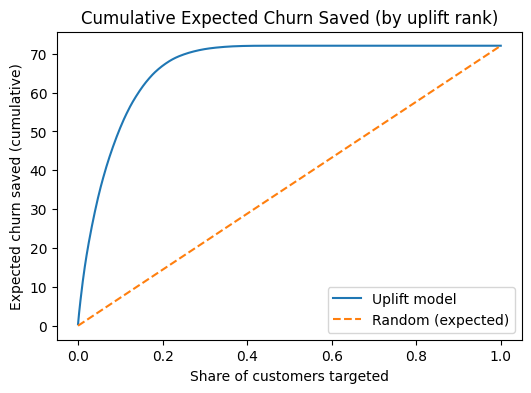

In [17]:
# 9) Simple cumulative expected saves curve (by uplift rank)
df_sorted = test_df.sort_values("uplift", ascending=False).reset_index(drop=True)
cum_expected_saves = np.cumsum(df_sorted["uplift"].clip(lower=0))

x = np.linspace(0, 1, len(cum_expected_saves))
plt.figure(figsize=(6,4))
plt.plot(x, cum_expected_saves, label="Uplift model")
plt.plot([0,1], [0, cum_expected_saves.iloc[-1] if len(cum_expected_saves)>0 else 0], "--", label="Random (expected)")
plt.title("Cumulative Expected Churn Saved (by uplift rank)")
plt.xlabel("Share of customers targeted")
plt.ylabel("Expected churn saved (cumulative)")
plt.legend()
plt.show()


10) Budget-aware pick (profit = uplift × CLV − cost)

In [18]:
# 10) Budget-aware selection on TEST
test_df["expected_profit"] = test_df["uplift"] * CLV - TREATMENT_COST
pick = test_df.sort_values("expected_profit", ascending=False).head(BUDGET_TREATS)

print(f"Selected {len(pick):,} customers | Expected profit ≈ {pick['expected_profit'].sum():,.0f}")
pick[["customer_id","uplift","p_ctrl","p_treat","uplift_segment","expected_profit"]].head(10)


Selected 3,306 customers | Expected profit ≈ -38,636


,customer_id,uplift,p_ctrl,p_treat,uplift_segment,expected_profit
9984,CUST09984,0.386487,0.655329,0.268842,Persuadable,93.621731
2179,CUST02179,0.385483,0.578564,0.193081,Persuadable,93.370702
1038,CUST01038,0.361843,0.906657,0.544814,Persuadable,87.460710
8812,CUST08812,0.361117,0.484348,0.123232,Persuadable,87.279214
1204,CUST01204,0.352295,0.512454,0.160159,Persuadable,85.073758
8904,CUST08904,0.345787,0.725023,0.379237,Persuadable,83.446688
8001,CUST08001,0.336472,0.711519,0.375047,Persuadable,81.117962
5482,CUST05482,0.332639,0.694121,0.361482,Persuadable,80.159752
1346,CUST01346,0.330597,0.560929,0.230332,Persuadable,79.649196
6888,CUST06888,0.325444,0.460649,0.135205,Persuadable,78.360883


11) Save outputs

In [19]:
# 11) Save scored TEST and campaign list
test_out_cols = [
    "customer_id","treatment","outcome",
    "p_ctrl","p_treat","uplift",
    "uplift_segment","policy_action","expected_profit"
]
test_df[test_out_cols + [c for c in test_df.columns if c not in test_out_cols]] \
    .to_csv("test_uplift_scored.csv", index=False)

pick.to_csv("campaign_selection.csv", index=False)
print("Saved: test_uplift_scored.csv, campaign_selection.csv")


Saved: test_uplift_scored.csv, campaign_selection.csv
